### Notebook to test out vortex tracking from WRF TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
June 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
# from smooth_runn_mn import smooth_runn_mn
from scipy import ndimage
from relvort import relvort
from object_track import object_track
# import cmocean
# from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
# from stratiform_index import stratiform_index

#### Directories

In [2]:
# figdir = "/Users/jruppert/code/tc_figs/"
# main = "/Users/jruppert/code/tc_output/"

# figdir = "/Users/jamesruppert/code/git/tc_figs/"
# main = "/Users/jamesruppert/code/tc_output/"
# main+= 'haiyan'

figdir = "/home/jamesrup/figures/tc/ens/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

storm = !ls $main

# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]
print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
# datdir = main+'/memb_01/ctl/'
datdir += 'post/d02/'
print(datdir)

/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ctl/post/d02/


#### Read variables

In [3]:
# LonLat
# fil = Dataset(datdir+'../../LATLON.nc') # this opens the netcdf file
fil = Dataset(datdir+'../../wrfout_d02_2013-11-01_00:00:00') # this opens the netcdf file
lon = fil.variables['XLONG'][:][0] # deg
lon1d=lon[0,:]
lat = fil.variables['XLAT'][:][0] # deg
lat1d=lat[:,0]
fil.close()
llshape=np.shape(lon)
nx = llshape[1]
ny = llshape[0]

# Pressure
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
# nz = np.shape(pres)[0]

In [4]:
# Level selection
ptrack=600 # tracking pressure level
ikread = np.where(pres == ptrack)[0][0]
print('Tracking at:',round(pres[ikread]),'hPa')

Tracking at: 600 hPa


In [5]:
# Horizontal wind
ufil = Dataset(datdir+'U.nc') # this opens the netcdf file
u = ufil.variables['U'][:,ikread,:,:] # m/s
ufil.close()
vfil = Dataset(datdir+'V.nc') # this opens the netcdf file
v = vfil.variables['V'][:,ikread,:,:] # m/s
vfil.close()

nt=np.shape(u)[0]

#### Calculate relative vorticity

$\zeta=\hat k \cdot \nabla \times \vec{U} = \dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y}$

For spherical: $\dfrac{\partial}{\partial y} \rightarrow \dfrac{\partial}{a\partial \Phi}$ and $\dfrac{\partial}{ \partial x} \rightarrow \dfrac{\partial}{a \text{cos}(\Phi) \partial \lambda}$, where $\lambda$ is longitude, $a$ is Earth radius, and $\Phi$ is latitude.

In [6]:
# print("Shape of gradient variable:",np.shape(dvdx))
vor=relvort(u,v,lat1d,lon1d)

#### Conduct tracking

In [7]:
track, f_masked = object_track(vor, lon, lat)
clon=track[0,:]
clat=track[1,:]

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 162.7185821533203 162.56629943847656 162.40953063964844
 162.24830627441406 162.1178436279297 162.0319366455078 161.92816162109375
 161.79762268066406 161.67678833007812 161.5733184814453
 161.47991943359375 161.38009643554688 161.25741577148438
 161.17884826660156 161.1050262451172 160.99172973632812
 160.80313110351562 160.59799194335938 160.36782836914062
 160.1441192626953 159.9345245361328 159.7378387451172 159.5624237060547
 159.41793823242188 159.2324676513672 159.09739685058594
 158.96534729003906 158.8163299560547 158.63003540039062 158.4516143798828
 158.2486114501953 158.0277099609375 157.74073791503906 157.3953399658203
 157.16793823242188 157.03256225585938 156.84246826171875
 156.64642333984375 156.3900146484375 156.13302612304688 155.96826171875
 155.80325317382812 155.6758270263672 155.5846710205078 155.4810333251953
 155.35195922851562 155.1825714111328 155.0880126953125 155.0254364013672
 154.96212

In [24]:
# Smooth vorticity
nx_sm=9    # Following Chavas 2013 (XX smoothing run x30 times)
# vor_smooth = object_track(vor, lon, lat, nx_sm)

# Localize around time-space maximum value
r_max=5 # [deg]

# 3-dimensional lon/lat for weighting
lon3d = np.repeat(lon[np.newaxis,:,:], nt, axis=0)
lat3d = np.repeat(lat[np.newaxis,:,:], nt, axis=0)
n_repeat=15
# Smooth input variable in x
f_smooth = ndimage.uniform_filter(vor,size=(0,nx_sm,nx_sm),mode='nearest')
for ido in range(n_repeat-1):
    f_smooth = ndimage.uniform_filter(f_smooth,size=(0,nx_sm,nx_sm),mode='nearest')

# Smooth input variable in time
# n_repeat=3
nt_smooth=3

# Smooth input variable in time
# for ido in range(n_repeat):
f_smooth = ndimage.uniform_filter(f_smooth,size=(nt_smooth,0,0),mode='nearest')

# Mask out values < 3 sigma
f_sigma = f_smooth / np.std(f_smooth)
f_masked = np.ma.array(f_sigma)
f_masked = np.ma.masked_where(np.abs(f_masked) < 3, f_masked, copy=False)

# Mask out first time step
f_masked[0,:,:] = np.nan
f_masked = np.ma.masked_invalid(f_masked, copy=False)

# Mask out data within 0.5*r_max from boundaries
f_masked = np.ma.masked_where(lon3d <= lon1d[0]+0.5*r_max, f_masked, copy=False)
f_masked = np.ma.masked_where(lon3d >= lon1d[nx-1]-0.5*r_max, f_masked, copy=False)
f_masked = np.ma.masked_where(lat3d <= lat1d[0]+0.5*r_max, f_masked, copy=False)
f_masked = np.ma.masked_where(lat3d >= lat1d[ny-1]-0.5*r_max, f_masked, copy=False)

# Localize around time-space maximum value
fmax = np.max(f_masked)
mloc=np.where(f_masked == fmax)
itmax = mloc[0][0]
xmax=mloc[2][0]
ymax=mloc[1][0]
# wsp = np.sqrt( u**2 + v**2 )
# wsp_masked = np.ma.array(wsp)

radius = np.sqrt( (lon-lon1d[xmax])**2 + (lat-lat1d[ymax])**2 )

# Mask surrounding points
for it in range(itmax-1,np.minimum(itmax+1,nt-1)+1):
    f_masked[it,:,:] = np.ma.masked_where(radius > r_max, f_masked[it,:,:], copy=False)
    # wsp_masked[it,:,:] = np.ma.masked_where(radius > r_max, wsp_masked[it,:,:], copy=False)

# Iterate downward from itmax
for it in range(itmax-1,1,-1):

    fmax = np.max(f_masked[it,:,:])
    mloc = np.where(f_masked[it,:,:] == fmax)
    xmax = mloc[1][0]
    ymax = mloc[0][0]
    # if it <= 36:
    #     print("IT = ",it)
    #     print(fmax)
    #     print(xmax)
    #     print(xmax)
    #     print()

    radius = np.sqrt( (lon-lon1d[xmax])**2 + (lat-lat1d[ymax])**2 )
    f_masked[it-1,:,:] = np.ma.masked_where(radius > r_max, f_masked[it-1,:,:], copy=False)
    # wsp_masked[it-1,:,:] = np.ma.masked_where(radius > r_max, wsp_masked[it-1,:,:], copy=False)

# Iterate upward from itmax
for it in range(itmax+1,nt-1):

    fmax = np.max(f_masked[it,:,:])
    mloc = np.where(f_masked[it,:,:] == fmax)
    xmax = mloc[1][0]
    ymax = mloc[0][0]

    radius = np.sqrt( (lon-lon1d[xmax])**2 + (lat-lat1d[ymax])**2 )
    f_masked[it+1,:,:] = np.ma.masked_where(radius > r_max, f_masked[it+1,:,:], copy=False)
    # wsp_masked[it+1,:,:] = np.ma.masked_where(radius > r_max, wsp_masked[it+1,:,:], copy=False)

# Track maxima in time by finding the centroid
clon2 = np.average(lon3d,axis=(1,2),weights=f_masked)
clat2 = np.average(lat3d,axis=(1,2),weights=f_masked)
track2=np.stack([clon,clat])

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

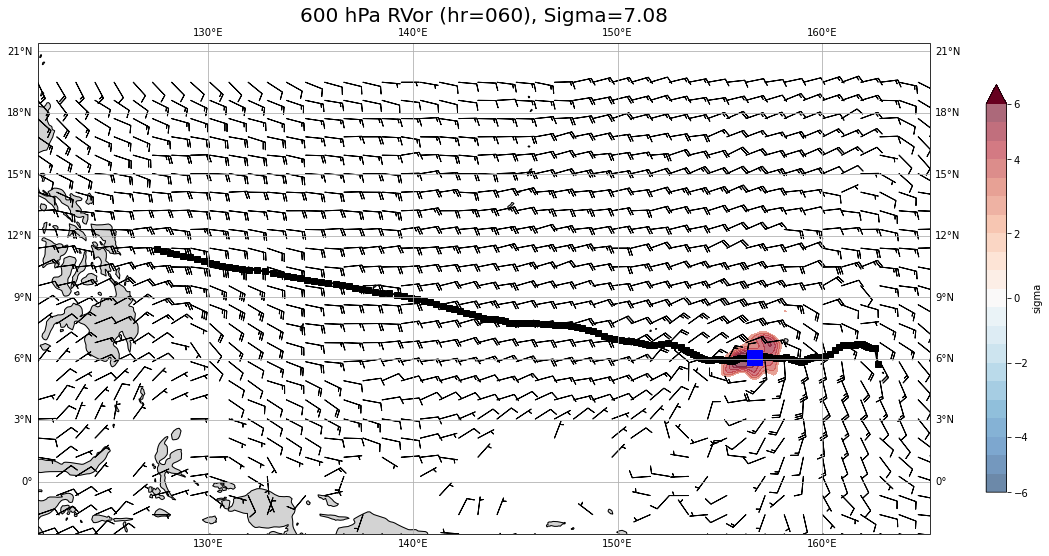

In [12]:
# select plotting area
plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(30,65):
for tsel in range(60,61):
# for tsel in range(167,168):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    
    iu = u[tsel,:,:]
    iv = v[tsel,:,:]
    pltvar=f_masked[tsel,:,:]
    
    # sigma=np.std(pltvar)
    sigma=np.max(np.abs(pltvar))
    # print("Sigma = ",sigma)
    # pltvar/=sigma

    # create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
    ax.set_title(str(round(pres[ikread])) + ' hPa RVor (hr='+hr_tag+'), Sigma='+np.array2string(np.float16(sigma)), fontsize=20)

    # fill contour
    clevs = np.arange(0.5, 6, 0.5)
    clevs = np.concatenate((-1*np.flip(clevs),clevs))

    im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # wind barbs
    spacing=30#15 #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = iu * mps_to_kts
    vplt = iv * mps_to_kts
    # mask for speeds < 10 kts
    spd = np.sqrt(uplt**2+vplt**2)
    uplt=np.ma.masked_where(spd < 5, uplt, copy=False)

    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
                 uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2, length=6)

    # storm track
    plt.plot(clon, clat, color="black", linewidth=2)
    plt.plot(clon, clat, "s", color="black")
    # current time
    plt.plot(clon[tsel], clat[tsel], "s", color="blue", markersize=15)
    # all-time max (time step 168)
    # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
#     plt.savefig(figdir+'vort'+str(round(pres[ikread]))+'_smx'+str(nx_sm)+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
#               bbox_inches='tight', pad_inches=0.2)
    # plt.close()